# AIND - Project 2 - Build a Forward-Planning Agent
## Report

### Environment
The results were produced on a desktop computer with the following specification:
- OS: Ubuntu 20.04.2 LTS (64 bit)
- Memory: 23,4 GiB
- Processor: Intel Core i7-4790K CPU@4Ghz * 8
- GNU bash, version 5.0.17(1)-release (x86_64-pc-linux-gnu)
- Conda virutal environment: Python: 3.9.5

### Obtaining the data:
#### Problem 1 and 2
The provided `run_search.py` script was run the following way:
```bash 
$ parallel python run_search.py -p 1 2 -s {1} ::: {1..11} > results.txt
```
The GNU Parallel was utilized to run the processes simultaneously (this likely saves time for porblem 3 and 4, but ptobably not for problems 1 and 2 due to the overhead of each python process)
The `results.txt` was processed to consolidate the data in a nearly tabular format in an new file:
```bash
grep '^Solving*' -A 5 results.txt | grep -v -e '^$' > result_summary.txt
```

The `result_summary.txt` consist of records like this for each test scenario:
```text
Solving Air Cargo Problem 1 using breadth_first_search...
# Actions   Expansions   Goal Tests   New Nodes
    20          43          56         178    
Plan length: 6  Time elapsed in seconds: 0.0017708629602566361
--
```

#### Problems 3 and 4
Let's extract the data for problems 3 and 4 and concatenate the data frames for better context.
I'd run the test the for problems 3-4 with solutions 1-9, ie. I only dropped A* with `h_pg_max_level` and `h_pg_set_level`, due to their expected long computing time.  

```bash
parallel python run_search.py -p 3 4 -s {1} ::: {1..9} | tee results_prob34.txt
grep '^Solving*' -A 5 results_prob34.txt | grep -v -e '^$' > result_prob34_summary.txt
```
The following scipt was used to generate the dataframes:

In [36]:
import re
import collections
import pandas as pd

Result = collections.namedtuple('Result',['problem', 'search', 'heuristic', 'actions', 'exp', 'goal_tests', 'new_nodes', 'length', 'duration'])

def make_records(file_name: str) -> list[Result]:    
    with open(file_name, "r") as f:
        lines = f.readlines()

    longlines = []
    for l in lines:
        match_problem = re.compile(r"^Solving Air Cargo Problem (\d).[a-z]+ ([a-z].+)...$").match(l)
        if match_problem:
            current = match_problem.group(1)
            search = match_problem.group(2)
            match_h = re.compile(r".*with (\w+)").match(l)
            if match_h:
                heuristic = match_h.group(1)
            else:
                heuristic = "No heuristic"
            continue
        m_aegn = re.compile(r"^\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+$").match(l)    
        if m_aegn:
            (action, exp, goal_tests, new_nodes) = (m_aegn.group(1), m_aegn.group(2), m_aegn.group(3), m_aegn.group(4))
            continue

        m_length_dur = re.compile(r"^Plan length: (\d+).+Time elapsed in seconds: (\d+.?\d+)").match(l)
        if m_length_dur:        
            final = Result(current, search, heuristic, action, exp, goal_tests, new_nodes, m_length_dur.group(1), m_length_dur.group(2))
            longlines.append(final)
    
    return longlines

def make_dataframe(records: list[Result]) -> pd.DataFrame:
    df = pd.DataFrame.from_records(records, columns=Result._fields)
    df['exp'] = df['exp'].astype(int)
    df['actions'] = df['actions'].astype(int)
    df['goal_tests'] = df['goal_tests'].astype(int)
    df['new_nodes'] = df['new_nodes'].astype(int)
    df['length'] = df['length'].astype(int)
    df['duration'] = df['duration'].astype(float)
    rgx  = re.compile(r"([a-z|_]+)")
    df['algorithm'] = [rgx.match(x).group(1) if rgx.match(x) else None for x in df.search]
    df.style.set_properties(subset=["search"], **{'text-align': 'left'})
    return df

The unfiltered results summary is exhibited in the next tables problems 1&2 and 3&4 respectively:

In [37]:
df12 = make_dataframe(make_records("result_summary.txt"))
df12

,problem,search,heuristic,actions,exp,goal_tests,new_nodes,length,duration,algorithm
0,1,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,20,7,9,29,6,0.001078,greedy_best_first_graph_search
1,2,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,72,17,19,170,9,0.011406,greedy_best_first_graph_search
2,1,breadth_first_search,No heuristic,20,43,56,178,6,0.004031,breadth_first_search
3,2,breadth_first_search,No heuristic,72,3343,4609,30503,9,1.189047,breadth_first_search
4,1,astar_search with h_unmet_goals,h_unmet_goals,20,50,52,206,6,0.005937,astar_search
5,2,astar_search with h_unmet_goals,h_unmet_goals,72,2467,2469,22522,9,1.333430,astar_search
6,1,depth_first_graph_search,No heuristic,20,21,22,84,20,0.002146,depth_first_graph_search
7,2,depth_first_graph_search,No heuristic,72,624,625,5602,619,1.530638,depth_first_graph_search
8,1,uniform_cost_search,No heuristic,20,60,62,240,6,0.005838,uniform_cost_search
9,2,uniform_cost_search,No heuristic,72,5154,5156,46618,9,1.983656,uniform_cost_search


In [38]:
df34 = make_dataframe(make_records("result_prob34_summary.txt"))
df34

,problem,search,heuristic,actions,exp,goal_tests,new_nodes,length,duration,algorithm
0,3,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,88,25,27,230,15,0.021266,greedy_best_first_graph_search
1,4,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,104,29,31,280,18,0.036156,greedy_best_first_graph_search
2,3,greedy_best_first_graph_search with h_pg_levelsum,h_pg_levelsum,88,14,16,126,14,11.187342,greedy_best_first_graph_search
3,4,greedy_best_first_graph_search with h_pg_levelsum,h_pg_levelsum,104,17,19,165,17,14.288633,greedy_best_first_graph_search
4,3,astar_search with h_unmet_goals,h_unmet_goals,88,7388,7390,65711,12,2.692799,astar_search
5,4,astar_search with h_unmet_goals,h_unmet_goals,104,34330,34332,328509,14,25.140462,astar_search
6,3,breadth_first_search,No heuristic,88,14663,18098,129625,12,6.281926,breadth_first_search
7,4,breadth_first_search,No heuristic,104,99736,114953,944130,14,37.637637,breadth_first_search
8,3,uniform_cost_search,No heuristic,88,18510,18512,161936,12,8.537571,uniform_cost_search
9,4,uniform_cost_search,No heuristic,104,113339,113341,1066413,14,44.945992,uniform_cost_search


I concatenated the two datasets for analysis:

In [39]:
df = pd.concat([df12, df34], ignore_index=True)
df

,problem,search,heuristic,actions,exp,goal_tests,new_nodes,length,duration,algorithm
0,1,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,20,7,9,29,6,0.001078,greedy_best_first_graph_search
1,2,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,72,17,19,170,9,0.011406,greedy_best_first_graph_search
2,1,breadth_first_search,No heuristic,20,43,56,178,6,0.004031,breadth_first_search
3,2,breadth_first_search,No heuristic,72,3343,4609,30503,9,1.189047,breadth_first_search
4,1,astar_search with h_unmet_goals,h_unmet_goals,20,50,52,206,6,0.005937,astar_search
5,2,astar_search with h_unmet_goals,h_unmet_goals,72,2467,2469,22522,9,1.333430,astar_search
6,1,depth_first_graph_search,No heuristic,20,21,22,84,20,0.002146,depth_first_graph_search
7,2,depth_first_graph_search,No heuristic,72,624,625,5602,619,1.530638,depth_first_graph_search
8,1,uniform_cost_search,No heuristic,20,60,62,240,6,0.005838,uniform_cost_search
9,2,uniform_cost_search,No heuristic,72,5154,5156,46618,9,1.983656,uniform_cost_search


I grouped the data to make the comparisons easier:

In [40]:
df.groupby(by=["problem", "algorithm", "heuristic"], dropna=False).sum()

actions     exp  \
problem algorithm                      heuristic                        
1       astar_search                   h_pg_levelsum       20      28   
                                       h_pg_maxlevel       20      43   
                                       h_pg_setlevel       20      33   
                                       h_unmet_goals       20      50   
        breadth_first_search           No heuristic        20      43   
        depth_first_graph_search       No heuristic        20      21   
        greedy_best_first_graph_search h_pg_levelsum       20       6   
                                       h_pg_maxlevel       20       6   
                                       h_pg_setlevel       20       6   
                                       h_unmet_goals       20       7   
        uniform_cost_search            No heuristic        20      60   
2       astar_search                   h_pg_levelsum       72     357   
                                       h_pg_maxlevel       72    2887   
                                       h_pg_setlevel       72    1037   
                                       h_unmet_goals       72    2467   
        breadth_first_search           No heuristic        72    3343   
        depth_first_graph_search       No heuristic        72     624   
        greedy_best_first_graph_search h_pg_levelsum       72       9   
                                       h_pg_maxlevel       72      27   
                                       h_pg_setlevel       72       9   
                                       h_unmet_goals       72      17   
        uniform_cost_search            No heuristic        72    5154   
3       astar_search                   h_pg_levelsum       88     369   
                                       h_unmet_goals       88    7388   
        breadth_first_search           No heuristic        88   14663   
        depth_first_graph_search       No heuristic        88     408   
        greedy_best_first_graph_search h_pg_levelsum       88      14   
                                       h_pg_maxlevel       88      21   
                                       h_pg_setlevel       88      35   
                                       h_unmet_goals       88      25   
        uniform_cost_search            No heuristic        88   18510   
4       astar_search                   h_pg_levelsum      104    1208   
                                       h_unmet_goals      104   34330   
        breadth_first_search           No heuristic       104   99736   
        depth_first_graph_search       No heuristic       104   25174   
        greedy_best_first_graph_search h_pg_levelsum      104      17   
                                       h_pg_maxlevel      104      56   
                                       h_pg_setlevel      104     107   
                                       h_unmet_goals      104      29   
        uniform_cost_search            No heuristic       104  113339   

                                                      goal_tests  new_nodes  \
problem algorithm                      heuristic                              
1       astar_search                   h_pg_levelsum          30        122   
                                       h_pg_maxlevel          45        180   
                                       h_pg_setlevel          35        138   
                                       h_unmet_goals          52        206   
        breadth_first_search           No heuristic           56        178   
        depth_first_graph_search       No heuristic           22         84   
        greedy_best_first_graph_search h_pg_levelsum           8         28   
                                       h_pg_maxlevel           8         24   
                                       h_pg_setlevel           8         28   
                                       h_unmet_goals           9         29   
        uniform_cost_search            

And finally made a pivot table that exhibits 

In [56]:
table = pd.pivot_table(df,index=['algorithm','heuristic', 'problem'], values=['length', 'duration', 'exp'], aggfunc=sum)
table

duration     exp  \
algorithm                      heuristic     problem                       
astar_search                   h_pg_levelsum 1          0.733620      28   
                                             2         86.600762     357   
                                             3        129.196758     369   
                                             4        720.167901    1208   
                               h_pg_maxlevel 1          0.778406      43   
                                             2        483.368170    2887   
                               h_pg_setlevel 1          2.463442      33   
                                             2        791.994878    1037   
                               h_unmet_goals 1          0.005937      50   
                                             2          1.333430    2467   
                                             3          2.692799    7388   
                                             4         25.140462   34330   
breadth_first_search           No heuristic  1          0.004031      43   
                                             2          1.189047    3343   
                                             3          6.281926   14663   
                                             4         37.637637   99736   
depth_first_graph_search       No heuristic  1          0.002146      21   
                                             2          1.530638     624   
                                             3          0.625750     408   
                                             4        926.445908   25174   
greedy_best_first_graph_search h_pg_levelsum 1          0.290513       6   
                                             2          4.177993       9   
                                             3         11.187342      14   
                                             4         14.288633      17   
                               h_pg_maxlevel 1          0.223862       6   
                                             2         12.724622      27   
                                             3         18.385796      21   
                                             4         45.765652      56   
                               h_pg_setlevel 1          0.946502       6   
                                             2         11.029576       9   
                                             3         74.453106      35   
                                             4        233.629217     107   
                               h_unmet_goals 1          0.001078       7   
                                             2          0.011406      17   
                                             3          0.021266      25   
                                             4          0.036156      29   
uniform_cost_search            No heuristic  1          0.005838      60   
                                             2          1.983656    5154   
                                             3          8.537571   18510   
                                             4         44.945992  113339   

                                                      length  
algorithm                      heuristic     problem          
astar_search                   h_pg_levelsum 1             6  
                                             2             9  
                                             3            12  
                                             4            15  
                               h_pg_maxlevel 1             6  
                                             2             9  
                               h_pg_setlevel 1             6  
                                             2             9  
                               h_unmet_goals 1             6  
                                             2             9  
                                             3            12  
                                            

The  `exp`, `goal_tests` and `new_nodes` correlate closely, so I only consider `exp` in the further analysis. See the calculation and the subsequent chart for visual support

In [54]:
df['exp'].corr(df['new_nodes'])

0.9999143717407907

In [53]:
df['exp'].corr(df['goal_tests'])

0.9971199544230299

In [60]:
df['exp'].corr(df['duration'])

0.02757370827960647

As the graph shows the `A*` search grows exponentially in any case. 

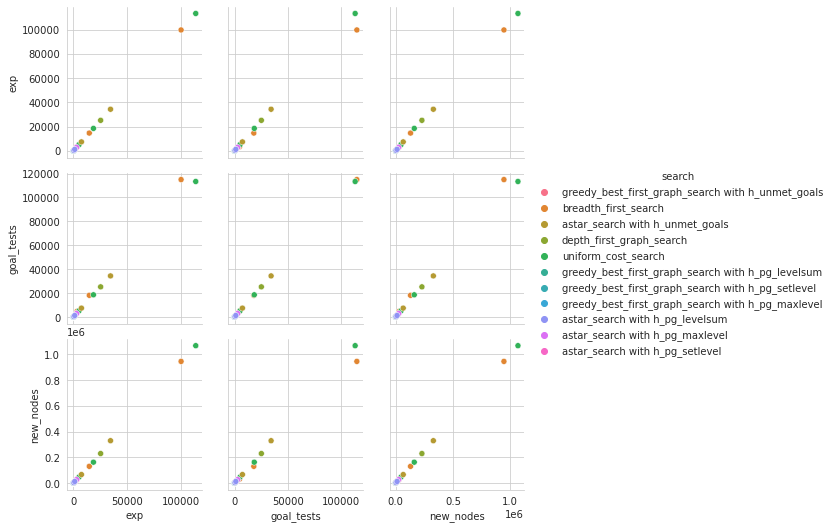

In [14]:
g = sns.PairGrid(df, vars=["exp", "goal_tests", "new_nodes"], hue="search")
#g.map_diag(sns.histplot)

g.map(sns.scatterplot)
g.add_legend()

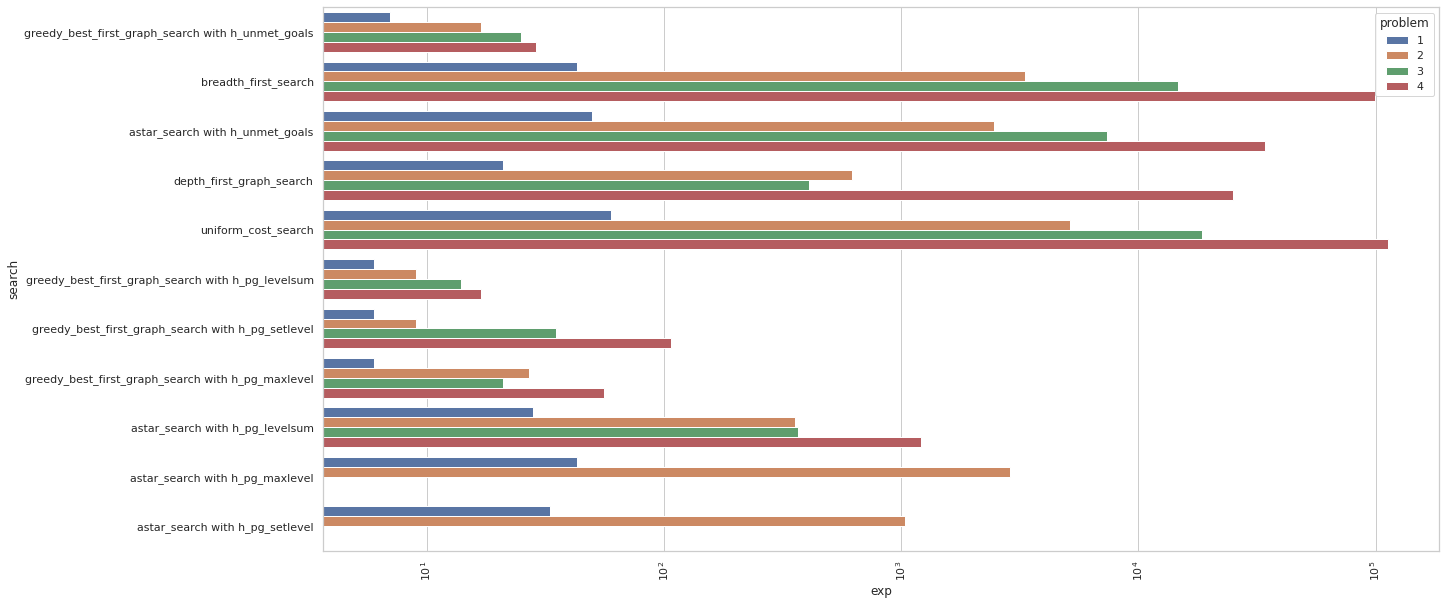

In [58]:
from matplotlib import pyplot
import seaborn as sns
sns.set_style("whitegrid")
fig, ax = pyplot.subplots(figsize=(20,10))
ax = sns.barplot(x="exp", y = "search", hue="problem", data=df)
plt.xticks(rotation=90)
plt.xscale("log")
plt.show()

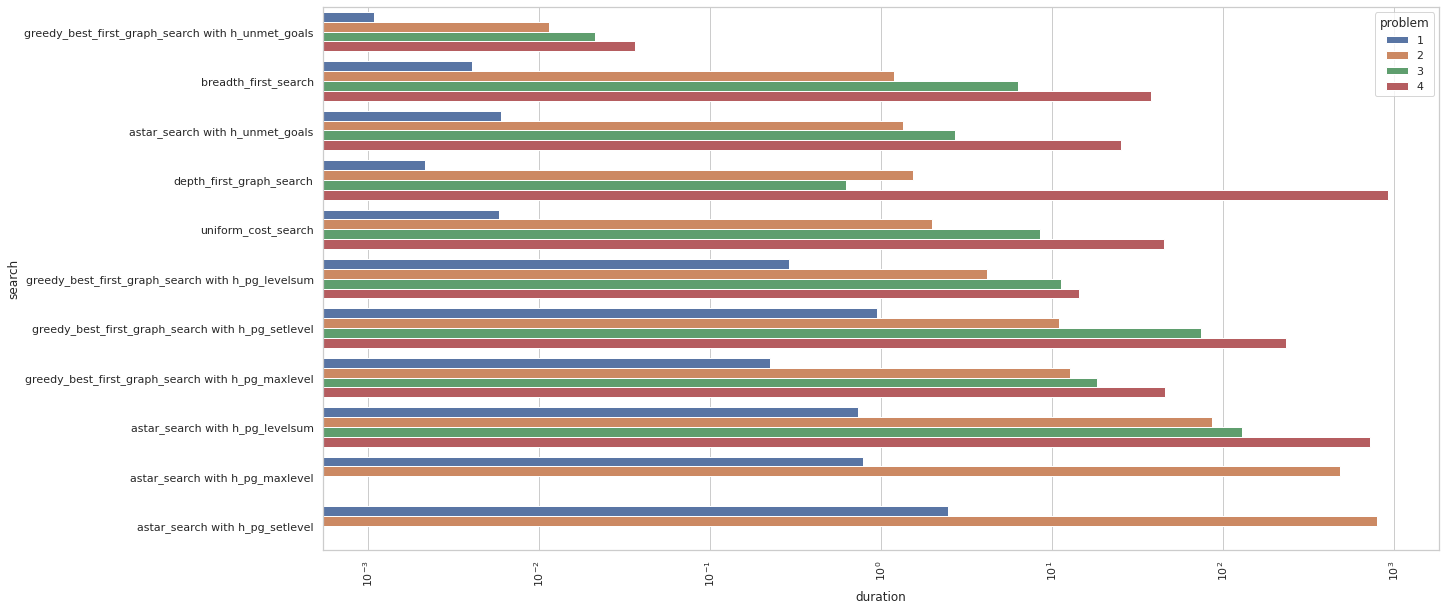

In [59]:
from matplotlib import pyplot
import seaborn as sns
sns.set_style("whitegrid")
fig, ax = pyplot.subplots(figsize=(20,10))
ax = sns.barplot(x="duration", y = "search", hue="problem", data=df)
plt.xticks(rotation=90)
plt.xscale("log")
plt.show()

See the development in durations for each search algorithm as the problem size grows.  
**Note** mind the logarithmic scale!

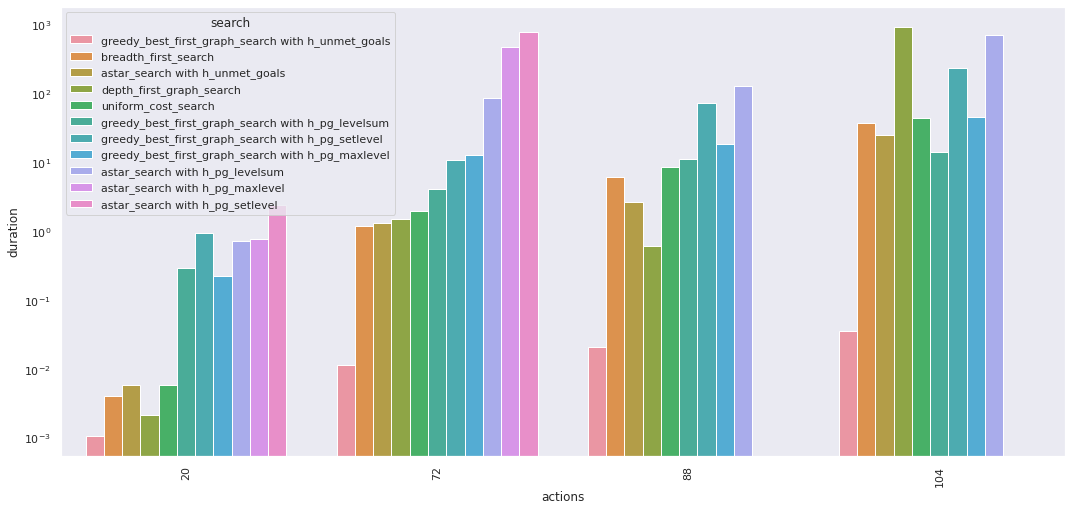

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
#ax = sns.lineplot(y="duration", x = "actions", data=df[df["search"]=="breadth_first_search"])
fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
ax = sns.barplot(y="duration", x = "actions", data=df, hue="search")
ax.set(yscale='log')
plt.xticks(rotation=90)
plt.show()

### Number of nodes expanded against number of actions in the domain
Here is the growth in number of expansions that roughly corresponds to memory use

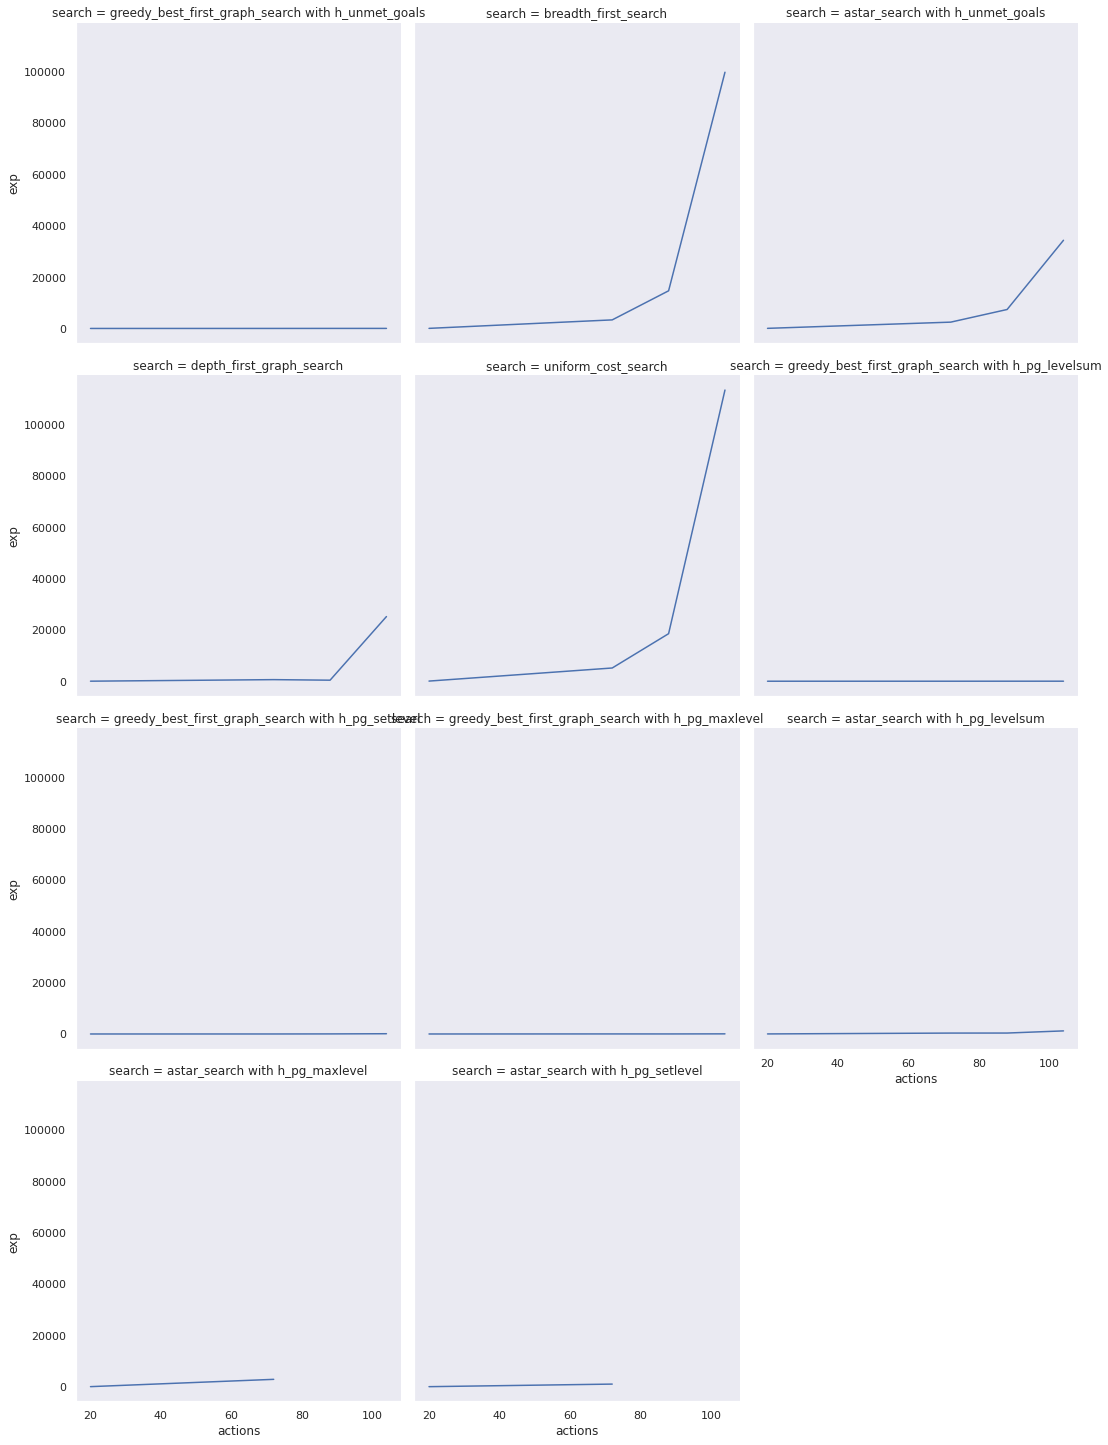

In [70]:
sns.relplot(data=df, x="actions", y="exp", col="search", col_wrap=3, kind="line")
#plt.ylim(0, 10000)

And the same plots against calculation time. The Y axis is culled to preserv the visibility of trends and still keep the linear perspective

(0.0, 400.0)

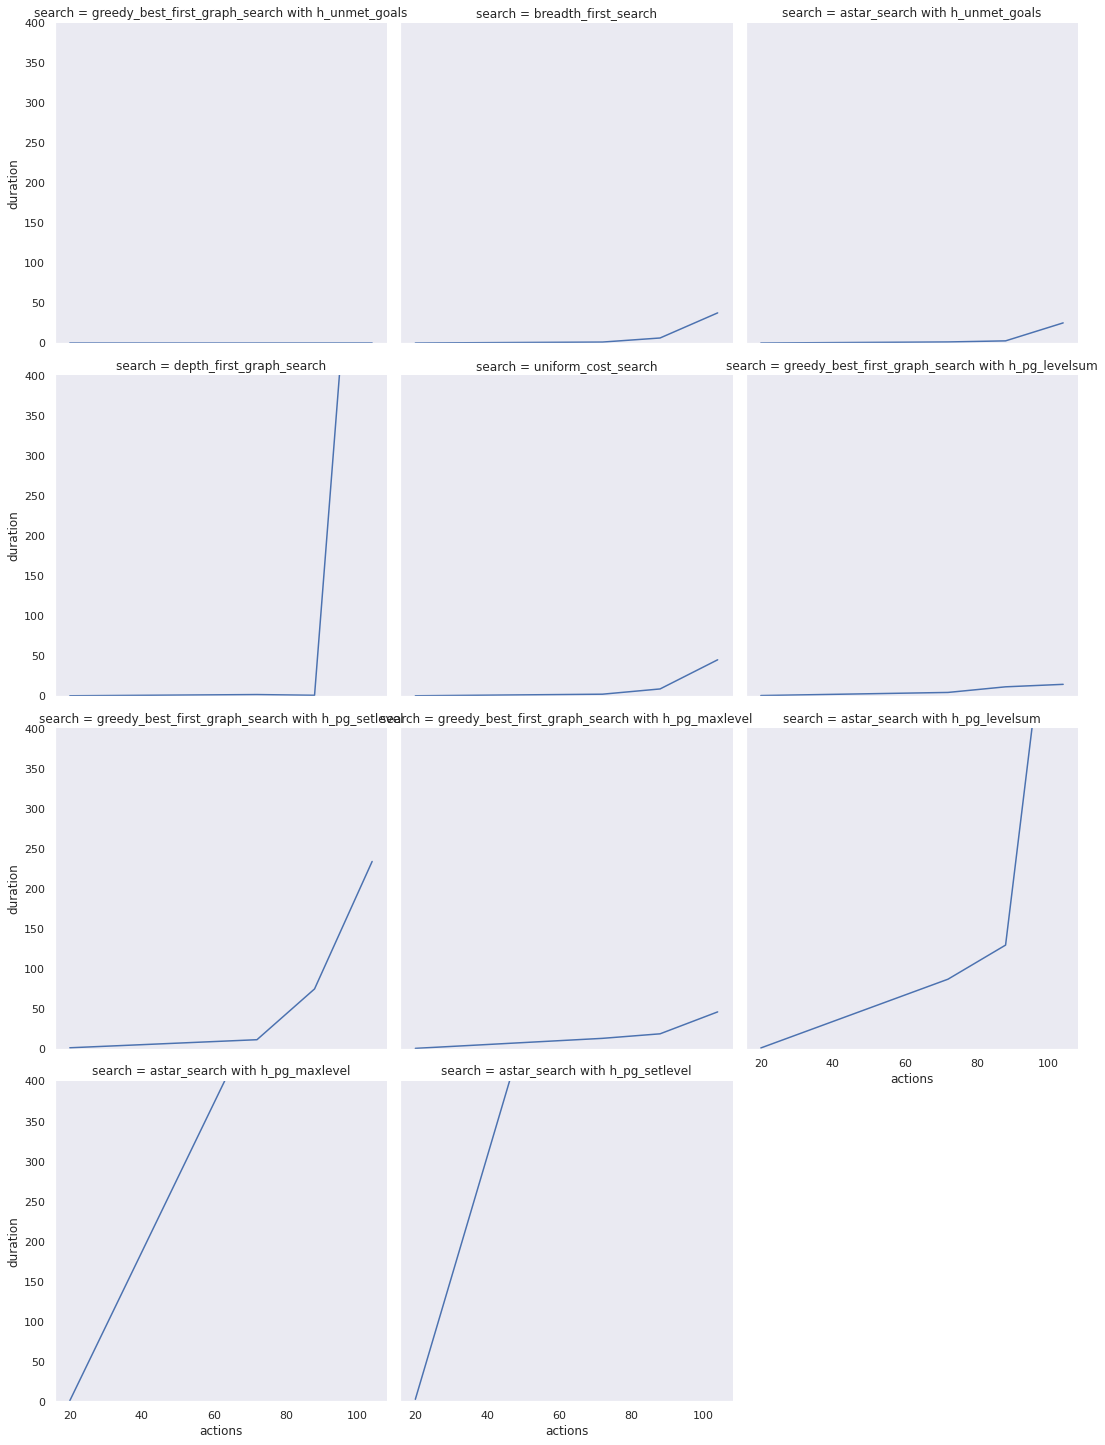

In [71]:
sns.relplot(data=df, x="actions", y="duration", col="search", col_wrap=3, kind="line")
plt.ylim(0, 400)

In [61]:
df['exp'].corr(df['duration'])

0.02757370827960647

# Conclusion
The `depth_first_graph_search` completely misses the mark, as the proposed solution is way too far from optimal. Any number of extra fliights (or even simpler physical actions) are way more expensive than the potential savings in computational time. 

## Complexity and gowth trends: 
### Search time vs. the number of actions in the domain.

See corresponding chart. 
Best algorithm is subomptimal path is acceptable for large domains:
`greedy_best_first_graph_search with h_unmet_goals`. 
The execution time makes this the best fit for real time applications.
If the path must be optimal then the 
`astar_search with h_unmet_goals` algorithm is the winner. This may not be good enogh for real time applications, but it still scales nicely while finding the optimal solution.
For smaller domains 

For small domains `greedy_best_first_graph_search with h_unmet_goals` is a really efficient algorithm that finds the oprimal path.

In [115]:
import pandasql as pdsql
pdsql.sqldf("SELECT problem, length, search, duration, exp from df \
                WHERE problem = 4 \
                ORDER BY length ASC, duration ASC")

,problem,length,search,duration,exp
0,4,14,astar_search with h_unmet_goals,25.140462,34330
1,4,14,breadth_first_search,37.637637,99736
2,4,14,uniform_cost_search,44.945992,113339
3,4,15,astar_search with h_pg_levelsum,720.167901,1208
4,4,17,greedy_best_first_graph_search with h_pg_levelsum,14.288633,17
5,4,17,greedy_best_first_graph_search with h_pg_maxlevel,45.765652,56
6,4,18,greedy_best_first_graph_search with h_unmet_goals,0.036156,29
7,4,23,greedy_best_first_graph_search with h_pg_setlevel,233.629217,107
8,4,24132,depth_first_graph_search,926.445908,25174


In [118]:
import pandasql as pdsql
pdsql.sqldf("SELECT problem, length, search, duration, exp from df \
                WHERE problem < 3 \
                ORDER BY duration ASC, length ASC")

,problem,length,search,duration,exp
0,1,6,greedy_best_first_graph_search with h_unmet_goals,0.001078,7
1,1,20,depth_first_graph_search,0.002146,21
2,1,6,breadth_first_search,0.004031,43
3,1,6,uniform_cost_search,0.005838,60
4,1,6,astar_search with h_unmet_goals,0.005937,50
5,2,9,greedy_best_first_graph_search with h_unmet_goals,0.011406,17
6,1,6,greedy_best_first_graph_search with h_pg_maxlevel,0.223862,6
7,1,6,greedy_best_first_graph_search with h_pg_levelsum,0.290513,6
8,1,6,astar_search with h_pg_levelsum,0.733620,28
9,1,6,astar_search with h_pg_maxlevel,0.778406,43


### number of nodes expanded vs. number of actions in the domain
If optimality is a goal the relatively memory hungry `astar_search with h_unmet_goals` is best.

If optimality is not a criterium, for larger problems, the `greedy_best_first_graph_search with h_pg_levelsum` is really easy on memory by only expanding the graph 17 times.


For small problems 
`greedy_best_first_graph_search with h_pg_levelsum` has both the lowest numer of expansions and finds the optimal solution.

In [119]:
import pandasql as pdsql
pdsql.sqldf("SELECT problem, length, search, duration, exp from df \
                WHERE problem = 4 \
                ORDER BY exp ASC, length ASC")

,problem,length,search,duration,exp
0,4,17,greedy_best_first_graph_search with h_pg_levelsum,14.288633,17
1,4,18,greedy_best_first_graph_search with h_unmet_goals,0.036156,29
2,4,17,greedy_best_first_graph_search with h_pg_maxlevel,45.765652,56
3,4,23,greedy_best_first_graph_search with h_pg_setlevel,233.629217,107
4,4,15,astar_search with h_pg_levelsum,720.167901,1208
5,4,24132,depth_first_graph_search,926.445908,25174
6,4,14,astar_search with h_unmet_goals,25.140462,34330
7,4,14,breadth_first_search,37.637637,99736
8,4,14,uniform_cost_search,44.945992,113339


In [120]:
import pandasql as pdsql
pdsql.sqldf("SELECT problem, length, search, duration, exp from df \
                WHERE problem < 3 \
                ORDER BY exp ASC, length ASC")

,problem,length,search,duration,exp
0,1,6,greedy_best_first_graph_search with h_pg_levelsum,0.290513,6
1,1,6,greedy_best_first_graph_search with h_pg_setlevel,0.946502,6
2,1,6,greedy_best_first_graph_search with h_pg_maxlevel,0.223862,6
3,1,6,greedy_best_first_graph_search with h_unmet_goals,0.001078,7
4,2,9,greedy_best_first_graph_search with h_pg_levelsum,4.177993,9
5,2,9,greedy_best_first_graph_search with h_pg_setlevel,11.029576,9
6,2,9,greedy_best_first_graph_search with h_unmet_goals,0.011406,17
7,1,20,depth_first_graph_search,0.002146,21
8,2,9,greedy_best_first_graph_search with h_pg_maxlevel,12.724622,27
9,1,6,astar_search with h_pg_levelsum,0.733620,28


In [124]:
pdsql.sqldf("SELECT problem, length, search, duration, exp from df \
                WHERE problem = 4 \
                ORDER BY length ASC, exp ASC \
                LIMIT 3")

,problem,length,search,duration,exp
0,4,14,astar_search with h_unmet_goals,25.140462,34330
1,4,14,breadth_first_search,37.637637,99736
2,4,14,uniform_cost_search,44.945992,113339


Answer to subission questions:
- Which algorithm or algorithms would be most appropriate for planning in a very restricted domain (i.e., one that has only a few actions) and needs to operate in real time?  
`greedy_best_first_graph_search with h_unmet_goals`
- Which algorithm or algorithms would be most appropriate for planning in very large domains (e.g., planning delivery routes for all UPS drivers in the U.S. on a given day)  
`astar_search with h_unmet_goals`, provided that optimality is required
- Which algorithm or algorithms would be most appropriate for planning problems where it is important to find only optimal plans?
`astar_search with h_unmet_goals`